## CSE 5367 – 001 Pattern Recognition

# Final Project - Hate Speech Detection


### Keerthi Patnaik (1002069181)
### Preethi Subramanian (1002059233)


In [1]:
! pip install textstat
! pip install wordcloud
! pip install -U gensim

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from textstat.textstat import textstat

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
%matplotlib inline


In [3]:
dataset = pd.read_csv("HateSpeechData.csv")
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
def class_to_name(cls):
    if cls == 0:
        return "hate speech"

    if cls == 1:
        return "offensive language"

    return "neither"


# Adding text length and class name as a field in the dataset
dataset["text length"] = dataset["tweet"].apply(len)
dataset["class_name"] = dataset["class"].apply(class_to_name)

dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,text length,class_name
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,140,neither
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85,offensive language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120,offensive language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62,offensive language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,offensive language


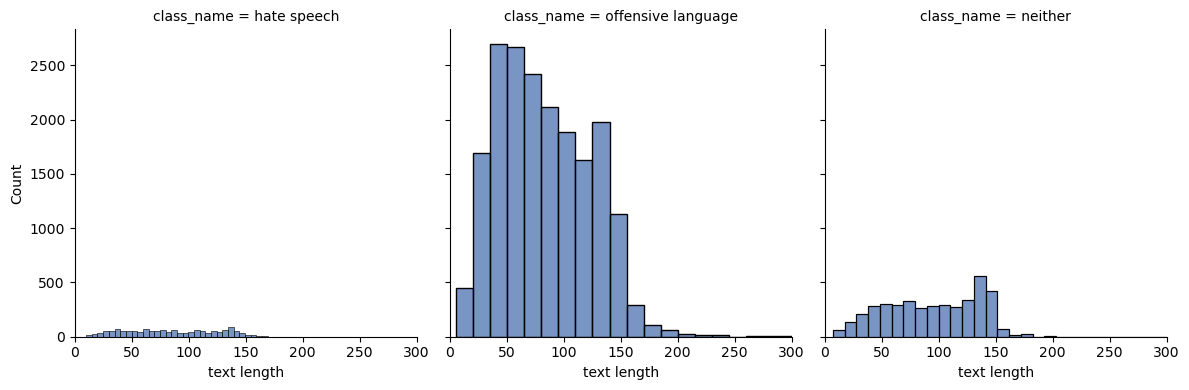

In [5]:
# Visualizing the dataset using a histogram of text length for each class
graph = sns.FacetGrid(
    data=dataset,
    col="class_name",
    xlim=[0, 300],
    height=4,
    col_order=["hate speech", "offensive language", "neither"],
)
graph.map(sns.histplot, "text length", bins=50)

The distribution of text length appears similar for all three classes. However, the number of offensive tweets is significantly higher.


<Axes: xlabel='class_name', ylabel='text length'>

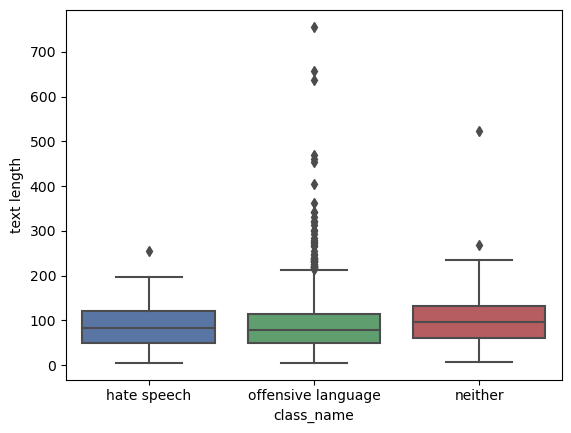

In [6]:
sns.boxplot(
    x="class_name",
    y="text length",
    data=dataset,
    order=["hate speech", "offensive language", "neither"],
)

Upon examining the plot, it appears that tweets containing offensive language have longer text length.


<Axes: >

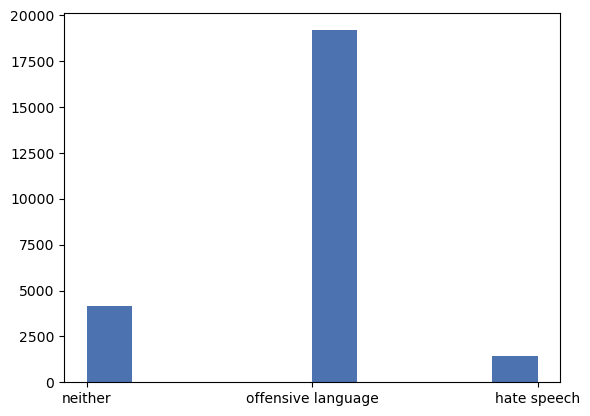

In [7]:
dataset["class_name"].hist(grid=False)

The above histogram shows that most of the tweets are considered to be offensive.


In [8]:
tweet = dataset.tweet

## Preprocessing the dataset


In [9]:
# Download necessary NLTK resources
nltk.download("stopwords")

# Set stopwords
stopwords = nltk.corpus.stopwords.words("english")
# extending the stopwords to include other words used in twitter such as retweet(rt)
stopwords.extend(["#ff", "ff", "rt"])

stemmer = PorterStemmer()


def preprocess(tweet):
    # Define patterns to remove URLs, mentions, non-letters, and numbers
    url_pattern = re.compile(r"http[s]?://\S+")
    mention_pattern = re.compile(r"@\w+")
    non_letter_pattern = re.compile(r"[^a-zA-Z\s]")
    number_pattern = re.compile(r"\d+(\.\d+)?")

    # Remove @mentions, URLs, non-letters, and numbers; convert to lowercase
    processed_tweets = (
        tweet.str.replace(url_pattern, "", regex=True)
        .str.replace(mention_pattern, "", regex=True)
        .str.replace(non_letter_pattern, " ", regex=True)
        .str.replace(number_pattern, "numbr", regex=True)
        .str.lower()
        .str.strip()
        .str.split()
    )

    # Remove stopwords and apply stemming
    processed_tweets = processed_tweets.apply(
        lambda tokens: " ".join(
            stemmer.stem(token) for token in tokens if token not in stopwords
        )
    )

    return processed_tweets


processed_tweets = preprocess(tweet)

dataset["processed_tweets"] = processed_tweets
dataset[["tweet", "processed_tweets"]].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Keerthi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet,processed_tweets
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain clean hous amp man alway take t...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat cold tyga dwn bad cuffin dat hoe st place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",shit blow claim faith somebodi still fuck hoe
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",sit hate anoth bitch got much shit go
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,caus tire big bitch come us skinni girl
8,""" &amp; you might not get ya bitch back &amp; ...",amp might get ya bitch back amp that
9,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbi includ fight mariam bitch


In [10]:
# Train a logistic regression model on the provided training data
# and evaluates its performance on the test data.
def logistic_regression_evaluation(X_train, X_test, y_train, y_test):
    lg_model = LogisticRegression()

    lg_model.fit(X_train, y_train)
    y_pred = lg_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, report, accuracy


# Train a random forest model on the provided training data
# and evaluates its performance on the test data.
def random_forest_evaluation(X_train, X_test, y_train, y_test):
    random_forest_model = RandomForestClassifier()

    random_forest_model.fit(X_train, y_train)
    y_pred = random_forest_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, report, accuracy


# Train a Gaussian Naive Bayes model on the provided training data
# and evaluates its performance on the test data.
def gaussian_nb_evaluation(X_train, X_test, y_train, y_test):
    gaussian_nb_model = GaussianNB()

    if type(X_train) == scipy.sparse._csr.csr_matrix:
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    gaussian_nb_model.fit(X_train, y_train)
    y_pred = gaussian_nb_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, report, accuracy


# Train a linear SVC model on the provided training data
# and evaluates its performance on the test data.
def linear_svc_evaluation(X_train, X_test, y_train, y_test):
    linear_svc_model = LinearSVC(random_state=20)

    linear_svc_model.fit(X_train, y_train)
    y_pred = linear_svc_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, report, accuracy


# Train an AdaBoost model on the provided training data
# and evaluates its performance on the test data.
def adaboost_evaluation(X_train, X_test, y_train, y_test):
    adaboost_model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100,
        learning_rate=1.0,
        random_state=42,
    )

    adaboost_model.fit(X_train, y_train)
    y_pred = adaboost_model.predict(X_test)

    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return y_pred, report, accuracy


# Evaluate the performance of the models on the provided dataset
def evaluate_models(X_train, X_test, y_train, y_test):
    _, lr_report, lr_accuracy = logistic_regression_evaluation(
        X_train, X_test, y_train, y_test
    )
    _, rf_report, rf_accuracy = random_forest_evaluation(
        X_train, X_test, y_train, y_test
    )
    _, gnb_report, gnb_accuracy = gaussian_nb_evaluation(
        X_train, X_test, y_train, y_test
    )
    _, lsvc_report, lsvc_accuracy = linear_svc_evaluation(
        X_train, X_test, y_train, y_test
    )
    _, ada_report, ada_accuracy = adaboost_evaluation(X_train, X_test, y_train, y_test)

    print("\nLogistic Regression")
    print(lr_report)
    print("Accuracy Score:", lr_accuracy)
    print("----------------------------------------------------------")

    print("\nRandom Forest")
    print(rf_report)
    print("Accuracy Score:", rf_accuracy)
    print("----------------------------------------------------------")

    print("\nNaive Bayes")
    print(gnb_report)
    print("Accuracy Score:", gnb_accuracy)
    print("----------------------------------------------------------")

    print("\nLinear SVC")
    print(lsvc_report)
    print("Accuracy Score:", lsvc_accuracy)
    print("----------------------------------------------------------")

    print("\nAdaBoost")
    print(ada_report)
    print("Accuracy Score:", ada_accuracy)
    print("----------------------------------------------------------")

    accuracies = [lr_accuracy, rf_accuracy, gnb_accuracy, lsvc_accuracy, ada_accuracy]

    return accuracies


# Plot the evaluation report for the models
def plot_evaluation_report(accuracies, title="Model Accuracies"):
    models = [
        "Logistic Regression",
        "Random Forest",
        "Gaussian NB",
        "Linear SVC",
        "AdaBoost",
    ]

    plt.figure(figsize=(10, 5))
    plt.bar(models, accuracies)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()

In [11]:
text_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.75, min_df=5, max_features=10000
)

# TF-IDF feature matrix
text_features = text_vectorizer.fit_transform(dataset["processed_tweets"])
tfidf_array = text_features.toarray()

### Using TFIDF to train multiple models without extra features


In [12]:
X = text_features
y = dataset["class"].astype(int)

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)

In [13]:
tfidf_accuracies = evaluate_models(X_train_tfidf, X_test_tfidf, y_train, y_test)


Logistic Regression
              precision    recall  f1-score   support

           0       0.56      0.18      0.27       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.84      0.85       835

    accuracy                           0.90      4957
   macro avg       0.77      0.66      0.68      4957
weighted avg       0.88      0.90      0.88      4957

Accuracy Score: 0.8977203954004438
----------------------------------------------------------

Random Forest
              precision    recall  f1-score   support

           0       0.54      0.18      0.27       290
           1       0.93      0.96      0.94      3832
           2       0.83      0.92      0.87       835

    accuracy                           0.91      4957
   macro avg       0.77      0.69      0.70      4957
weighted avg       0.89      0.91      0.89      4957

Accuracy Score: 0.905184587452088
----------------------------------------------------------

Naive Bayes
  

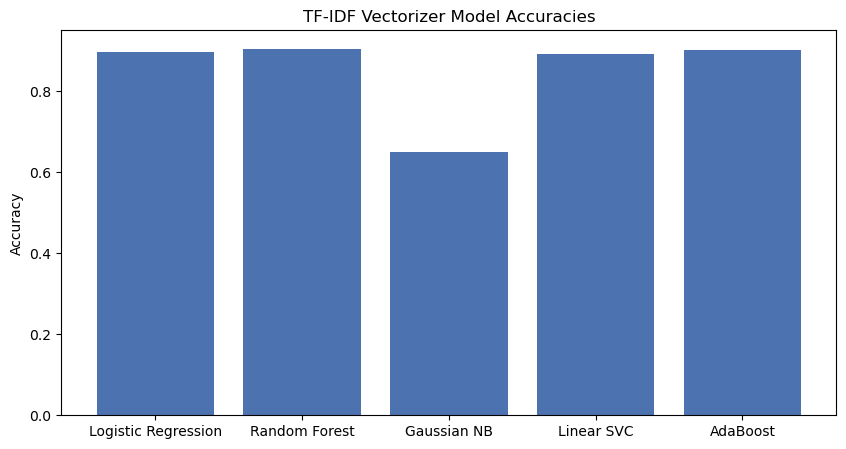

In [14]:
plot_evaluation_report(tfidf_accuracies, "TF-IDF Vectorizer Model Accuracies")

### Using polarity scores as features from Sentiment Analysis


In [15]:
# Download the VADER lexicon for sentiment analysis
nltk.download("vader_lexicon")

# Initialize the sentiment intensity analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()


def count_tags(text):
    # Patterns for matching spaces, URLs, mentions, and hashtags
    space_pattern = r"\s+"
    url_pattern = r"http[s]?://\S+"
    mention_pattern = r"@[\w\-]+"
    hashtag_pattern = r"#[\w\-]+"

    # Replace matches with placeholders
    text = re.sub(space_pattern, " ", text)
    text = re.sub(url_pattern, "URLHERE", text)
    text = re.sub(mention_pattern, "MENTIONHERE", text)
    text = re.sub(hashtag_pattern, "HASHTAGHERE", text)

    # Count occurrences of each placeholder
    return (
        text.count("URLHERE"),
        text.count("MENTIONHERE"),
        text.count("HASHTAGHERE"),
    )


def sentiment_analysis(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    twitter_objs = count_tags(tweet)
    features = [
        sentiment["neg"],
        sentiment["pos"],
        sentiment["neu"],
        sentiment["compound"],
        *twitter_objs,  # Unpack the tag counts directly into the list
    ]
    return features


def sentiment_analysis_features(tweets):
    return np.array([sentiment_analysis(tweet) for tweet in tweets])


sentiment_features = sentiment_analysis_features(tweet)

# Create a DataFrame from the numpy array of features
new_features = pd.DataFrame(
    sentiment_features,
    columns=["Neg", "Pos", "Neu", "Compound", "url_tag", "mention_tag", "hash_tag"],
)

new_features

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Keerthi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Neg,Pos,Neu,Compound,url_tag,mention_tag,hash_tag
0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0
1,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0
2,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0
3,0.000,0.344,0.656,0.5673,0.0,2.0,0.0
4,0.249,0.081,0.669,-0.7762,0.0,1.0,1.0
...,...,...,...,...,...,...,...
24778,0.000,0.000,1.000,0.0000,0.0,3.0,3.0
24779,0.454,0.000,0.546,-0.8074,0.0,0.0,0.0
24780,0.000,0.219,0.781,0.4738,0.0,0.0,0.0
24781,0.573,0.000,0.427,-0.7717,0.0,0.0,0.0


### Using TFIDF and sentiment features to train multiple models


In [16]:
tfidf_sentiment_features = np.concatenate([tfidf_array, sentiment_features], axis=1)

X = pd.DataFrame(tfidf_sentiment_features)

X_train_sa, X_test_sa, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)

In [17]:
sa_accuracies = evaluate_models(X_train_sa, X_test_sa, y_train, y_test)


Logistic Regression
              precision    recall  f1-score   support

           0       0.59      0.18      0.28       290
           1       0.92      0.96      0.94      3832
           2       0.85      0.84      0.84       835

    accuracy                           0.90      4957
   macro avg       0.78      0.66      0.69      4957
weighted avg       0.89      0.90      0.88      4957

Accuracy Score: 0.898325600161388
----------------------------------------------------------

Random Forest
              precision    recall  f1-score   support

           0       0.51      0.14      0.22       290
           1       0.91      0.96      0.94      3832
           2       0.84      0.84      0.84       835

    accuracy                           0.89      4957
   macro avg       0.75      0.65      0.66      4957
weighted avg       0.88      0.89      0.88      4957

Accuracy Score: 0.8936856969941497
----------------------------------------------------------

Naive Bayes
  

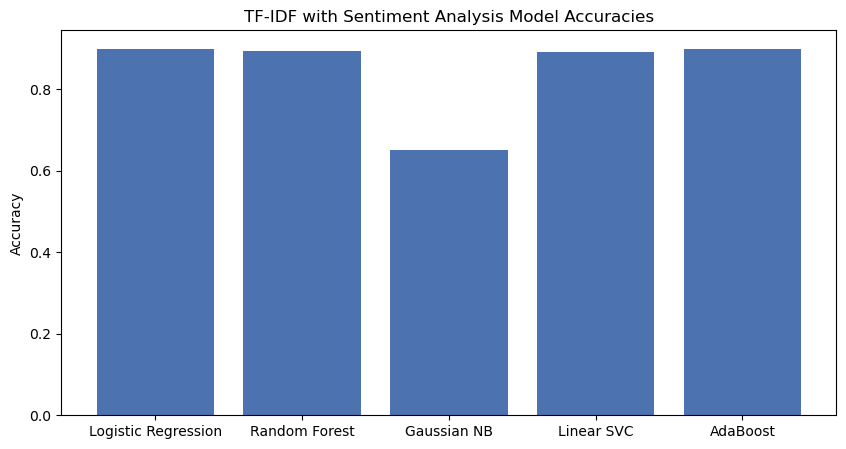

In [18]:
plot_evaluation_report(sa_accuracies, "TF-IDF with Sentiment Analysis Model Accuracies")

### Doc2Vec Vector Columns


In [19]:
# Prepare the data for Doc2Vec model
# Each tweet is tokenized and tagged with its index in the dataset
tagged_documents = [
    TaggedDocument(words=tweet.split(" "), tags=[index])
    for index, tweet in enumerate(dataset["processed_tweets"])
]

doc2vec_model = Doc2Vec(
    documents=tagged_documents, vector_size=5, window=2, min_count=1, workers=4
)


# Transform tweets into their vector representation using the trained Doc2Vec model
def tweet_to_vector(tweet):
    return doc2vec_model.infer_vector(tweet.split(" "))


# Transform each tweet in the 'processed_tweets' column to a vector, and convert the result to a DataFrame
doc_vectors = dataset["processed_tweets"].apply(tweet_to_vector).apply(pd.Series)

# Rename columns to 'doc2vec_vector_X' where X is the column index
doc_vectors.columns = ["doc2vec_vector_" + str(i) for i in doc_vectors.columns]

doc_vectors

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,0.087699,-0.012394,-0.136874,-0.107608,0.102188
1,0.154739,0.083603,0.120069,0.126898,-0.042112
2,-0.019824,0.023394,0.058932,-0.113951,-0.019521
3,0.068563,0.050330,0.066745,-0.024027,0.073257
4,0.046394,-0.007000,0.124255,-0.158435,-0.086976
...,...,...,...,...,...
24778,0.142136,0.019422,0.288841,-0.183006,0.174020
24779,0.097965,0.149767,-0.098101,-0.168777,-0.106629
24780,-0.089103,0.219651,-0.053201,-0.009310,-0.279274
24781,0.095359,0.099429,0.092663,-0.114187,-0.149219


### Using TFIDF with sentiment features and doc2vec to train multiple models


In [20]:
tfidf_sa_d2v_features = np.concatenate(
    [tfidf_array, sentiment_features, doc_vectors], axis=1
)

X = pd.DataFrame(tfidf_sa_d2v_features)

X_train_d2v, X_test_d2v, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2
)

In [21]:
d2v_accuracies = evaluate_models(X_train_d2v, X_test_d2v, y_train, y_test)


Logistic Regression
              precision    recall  f1-score   support

           0       0.60      0.18      0.28       290
           1       0.92      0.97      0.94      3832
           2       0.85      0.85      0.85       835

    accuracy                           0.90      4957
   macro avg       0.79      0.67      0.69      4957
weighted avg       0.89      0.90      0.89      4957

Accuracy Score: 0.9001412144442204
----------------------------------------------------------

Random Forest
              precision    recall  f1-score   support

           0       0.50      0.07      0.12       290
           1       0.90      0.97      0.94      3832
           2       0.86      0.79      0.82       835

    accuracy                           0.89      4957
   macro avg       0.75      0.61      0.63      4957
weighted avg       0.87      0.89      0.87      4957

Accuracy Score: 0.8898527335081703
----------------------------------------------------------

Naive Bayes
 

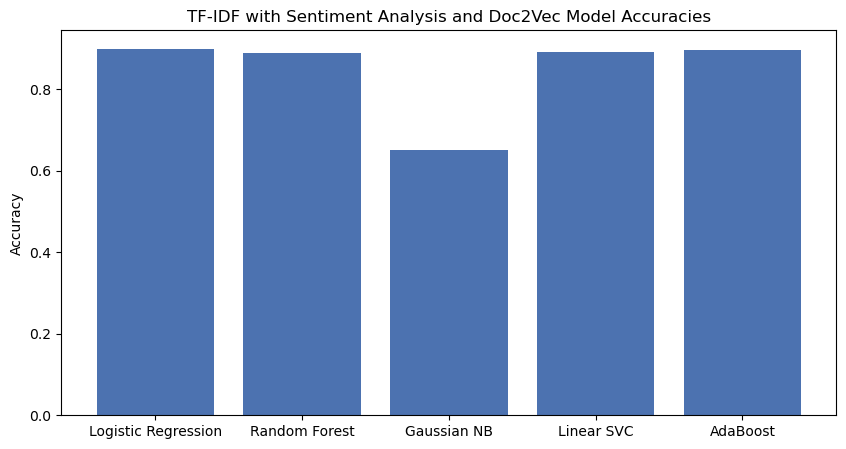

In [22]:
plot_evaluation_report(
    d2v_accuracies, "TF-IDF with Sentiment Analysis and Doc2Vec Model Accuracies"
)

In [23]:
# Calculate readability features for a given tweet
def calculate_readability_features(tweet):
    # Count the number of syllables in the text
    syllable_count = textstat.syllable_count(tweet)
    # Count the total number of characters excluding spaces
    character_count_excluding_spaces = sum(len(word) for word in tweet)
    # Count the total number of characters including spaces
    character_count_including_spaces = len(tweet)
    # Count the number of words
    word_count = len(tweet.split())
    # Calculate the average number of syllables per word
    average_syllables_per_word = round(
        (syllable_count + 0.001) / (word_count + 0.001), 4
    )
    # Count the number of unique words
    unique_word_count = len(set(tweet.split()))

    # Calculate the Flesch-Kincaid Readability Score
    flesch_kincaid_readability = round(
        0.39 * word_count + 11.8 * average_syllables_per_word - 15.59, 1
    )
    # Calculate the Flesch Reading Ease Score
    flesch_reading_ease = round(
        206.835 - 1.015 * word_count - 84.6 * average_syllables_per_word, 2
    )

    readability_features = [
        flesch_kincaid_readability,
        flesch_reading_ease,
        syllable_count,
        average_syllables_per_word,
        character_count_excluding_spaces,
        character_count_including_spaces,
        word_count,
        unique_word_count,
    ]

    return readability_features


# Extract enhanced readability features from a collection of tweets
def extract_enhanced_features_from_tweets(tweets):
    return np.array([calculate_readability_features(tweet) for tweet in tweets])


enhanced_features = extract_enhanced_features_from_tweets(processed_tweets)
enhanced_features

array([[  3.7 ,  84.9 ,  12.  , ...,  50.  ,   9.  ,   9.  ],
       [  2.6 ,  95.69,  13.  , ...,  49.  ,  11.  ,  10.  ],
       [  2.3 ,  92.97,  10.  , ...,  42.  ,   8.  ,   8.  ],
       ...,
       [  2.5 ,  95.17,  12.  , ...,  51.  ,  10.  ,  10.  ],
       [ -1.4 , 116.15,   6.  , ...,  30.  ,   6.  ,   6.  ],
       [  5.8 ,  76.5 ,  18.  , ...,  77.  ,  13.  ,  13.  ]])

### Using TFIDF with sentiment features,doc2vec and enhanced features to train multiple modles


In [24]:
tfidf_sa_d2v_enh_features = np.concatenate(
    [tfidf_array, sentiment_features, doc_vectors, enhanced_features], axis=1
)

X = pd.DataFrame(tfidf_sa_d2v_enh_features)

X_train_enh, X_test_enh, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2
)

In [25]:
enh_accuracies = evaluate_models(X_train_enh, X_test_enh, y_train, y_test)


Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       279
           1       0.84      0.95      0.89      3852
           2       0.64      0.43      0.52       826

    accuracy                           0.81      4957
   macro avg       0.83      0.46      0.47      4957
weighted avg       0.81      0.81      0.78      4957

Accuracy Score: 0.8133951987088965
----------------------------------------------------------

Random Forest
              precision    recall  f1-score   support

           0       0.50      0.06      0.10       279
           1       0.89      0.97      0.93      3852
           2       0.85      0.73      0.78       826

    accuracy                           0.88      4957
   macro avg       0.75      0.59      0.61      4957
weighted avg       0.86      0.88      0.86      4957

Accuracy Score: 0.881783336695582
----------------------------------------------------------

Naive Bayes
  

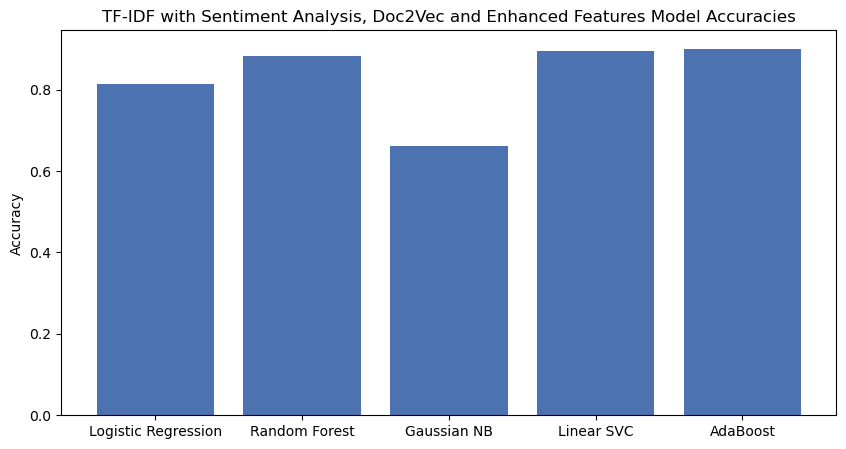

In [26]:
plot_evaluation_report(
    enh_accuracies,
    "TF-IDF with Sentiment Analysis, Doc2Vec and Enhanced Features Model Accuracies",
)

### Using TFIDF with sentiment fearures,doc2vec,enhanced features and word2vec to train multiple models


In [27]:
# Prepare the data for Word2Vec model
sentences = dataset["processed_tweets"].apply(lambda x: x.split(" ")).tolist()


word2vec_model = Word2Vec(sentences, vector_size=5, window=2, min_count=1, workers=4)


# Convert tweets to a vector
def document_vector(model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.index_to_key]
    if not doc:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)


# Apply the function to each document to get a vector
word_vectors = dataset["processed_tweets"].apply(
    lambda x: document_vector(word2vec_model, x.split(" "))
)
word_vectors = pd.DataFrame(word_vectors.tolist())
word_vectors.columns = [
    "word2vec_vector_" + str(i) for i in range(word_vectors.shape[1])
]

word_vectors

,word2vec_vector_0,word2vec_vector_1,word2vec_vector_2,word2vec_vector_3,word2vec_vector_4
0,0.477393,1.047343,3.002040,-1.695943,-0.514784
1,0.228817,1.008271,2.185996,-1.330619,-0.536284
2,0.041948,1.279049,2.856897,-1.665177,-0.862894
3,0.907234,1.945787,2.758926,-1.820140,-0.594829
4,0.157035,1.098243,2.626052,-1.403496,-0.738309
...,...,...,...,...,...
24778,0.174940,0.600728,1.499320,-0.843360,-0.202191
24779,0.243958,0.902655,2.421834,-1.358724,-0.514126
24780,0.478748,1.514069,2.679154,-1.652333,-0.706624
24781,-0.093642,1.025461,2.050463,-1.031344,-0.672996


In [28]:
tfidf_sa_d2v_enh_w2v_features = np.concatenate(
    [tfidf_array, sentiment_features, doc_vectors, enhanced_features, word_vectors],
    axis=1,
)

X = pd.DataFrame(tfidf_sa_d2v_enh_w2v_features)

X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size=0.2
)

In [29]:
w2v_accuracies = evaluate_models(X_train_w2v, X_test_w2v, y_train, y_test)


Logistic Regression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.88      0.96      0.91      3852
           2       0.72      0.65      0.68       826

    accuracy                           0.85      4957
   macro avg       0.53      0.54      0.53      4957
weighted avg       0.80      0.85      0.82      4957

Accuracy Score: 0.8519265684890055
----------------------------------------------------------

Random Forest
              precision    recall  f1-score   support

           0       0.52      0.04      0.08       279
           1       0.90      0.97      0.93      3852
           2       0.82      0.78      0.80       826

    accuracy                           0.89      4957
   macro avg       0.75      0.60      0.60      4957
weighted avg       0.87      0.89      0.86      4957

Accuracy Score: 0.8862215049425055
----------------------------------------------------------

Naive Bayes
 

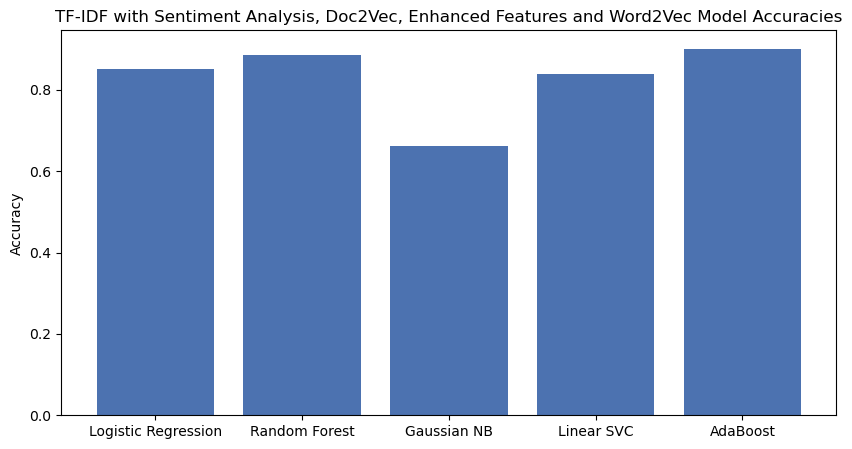

In [30]:
plot_evaluation_report(
    w2v_accuracies,
    "TF-IDF with Sentiment Analysis, Doc2Vec, Enhanced Features and Word2Vec Model Accuracies",
)

In [36]:
# table of accuracies in percentage
accuracies = {
    "TF-IDF": [round(acc * 100, 2) for acc in tfidf_accuracies],
    "TF-IDF + Sentiment Analysis": [round(acc * 100, 2) for acc in sa_accuracies],
    "TF-IDF + Sentiment Analysis + Doc2Vec": [
        round(acc * 100, 2) for acc in d2v_accuracies
    ],
    "TF-IDF + Sentiment Analysis + Doc2Vec + Enhanced Features": [
        round(acc * 100, 2) for acc in enh_accuracies
    ],
    "TF-IDF + Sentiment Analysis + Doc2Vec + Enhanced Features + Word2Vec": [
        round(acc * 100, 2) for acc in w2v_accuracies
    ],
}

accuracies_df = pd.DataFrame(accuracies)
accuracies_df.index = [
    "Logistic Regression",
    "Random Forest",
    "Naive Bayes",
    "Linear SVC",
    "AdaBoost",
]
accuracies_df.transpose()

,Logistic Regression,Random Forest,Naive Bayes,Linear SVC,AdaBoost
TF-IDF,89.77,90.52,64.92,89.27,90.05
TF-IDF + Sentiment Analysis,89.83,89.37,65.02,89.17,90.01
TF-IDF + Sentiment Analysis + Doc2Vec,90.01,88.99,65.02,89.27,89.67
TF-IDF + Sentiment Analysis + Doc2Vec + Enhanced Features,81.34,88.18,66.25,89.49,90.05
TF-IDF + Sentiment Analysis + Doc2Vec + Enhanced Features + Word2Vec,85.19,88.62,66.25,83.86,90.14


In [32]:
y_preds, _, _ = adaboost_evaluation(X_train_w2v, X_test_w2v, y_train, y_test)

Text(0.5, 63.222222222222186, 'Predicted Value')

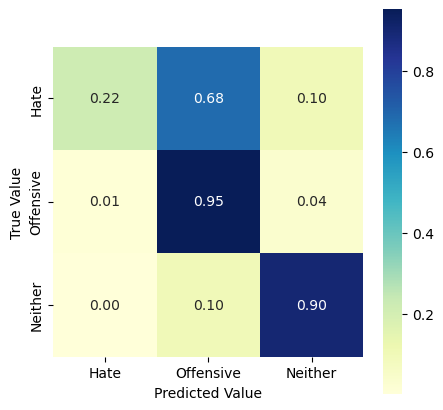

In [33]:
matrix = confusion_matrix(y_test, y_preds)

matrix_proportions = np.zeros((3, 3))
for i in range(0, 3):
    matrix_proportions[i, :] = matrix[i, :] / float(matrix[i, :].sum())

names = ["Hate", "Offensive", "Neither"]
confusion_df = pd.DataFrame(matrix_proportions, index=names, columns=names)

plt.figure(figsize=(5, 5))
sns.heatmap(
    confusion_df,
    annot=True,
    cmap="YlGnBu",
    square=True,
    fmt=".2f",
)
plt.ylabel("True Value")
plt.xlabel("Predicted Value")
plt.show()

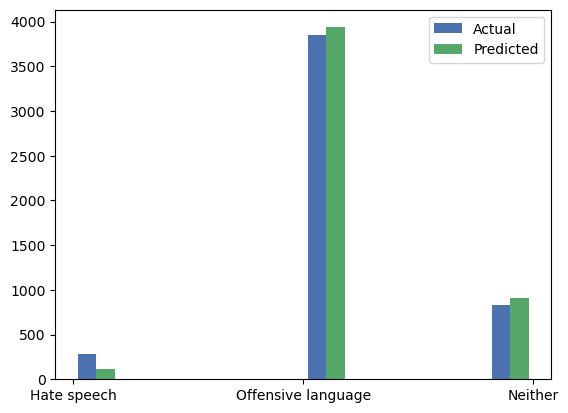

In [34]:
ax = plt.axes()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Hate speech", "Offensive language", "Neither"])

plt.hist([y_test, pd.Series(y_preds)], label=["Actual", "Predicted"])

plt.legend()
plt.show()